# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку.

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

In [14]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import scipy.stats as stats

import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

%matplotlib inline

In [15]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

In [16]:
df_train_features = pd.read_csv( "train_data.csv",
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv("train_targets.csv",
                                   index_col="match_id_hash")

In [17]:
df_train_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.000000,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.000000,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.250000,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.500000,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,0.000000,2,1,17,0,0.390244,2,2,0,0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,0.000000,6,2,10,0,0.263158,0,0,15,6
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,11.630505,0,0,15,1,0.555556,0,0,0,0


Отберем категориальные и числовые признаки.

In [18]:
numeric_features = ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh',
                    'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y',
                    'stuns', 'creeps_stacked', 'camps_stacked', 
                    'rune_pickups', 'teamfight_participation', 'towers_killed',
                    'roshans_killed', 'obs_placed', 'sen_placed']

In [19]:
hero_positions = ['r1', 'r2', 'r3', 'r4', 'r5', 'd1', 'd2', 'd3', 'd4', 'd5']

numeric_cols = [f"{position}_{feature}" for position in hero_positions for feature in numeric_features]
numeric_cols.extend(['game_time', 'objectives_len', 'chat_len'])


In [20]:
categorical_features = ['hero_id', 'first_blood_claimed']
cat_cols = [f"{position}_{feature}" for position in hero_positions for feature in categorical_features]
cat_cols.extend(['game_mode', 'lobby_type', 'objectives_len'])

Посмотрим на корреляции числовых признаков: сначала внутри одного героя, а потом для всех сразу

In [21]:
corr_hero = df_train_features[numeric_cols[:22]].corr()

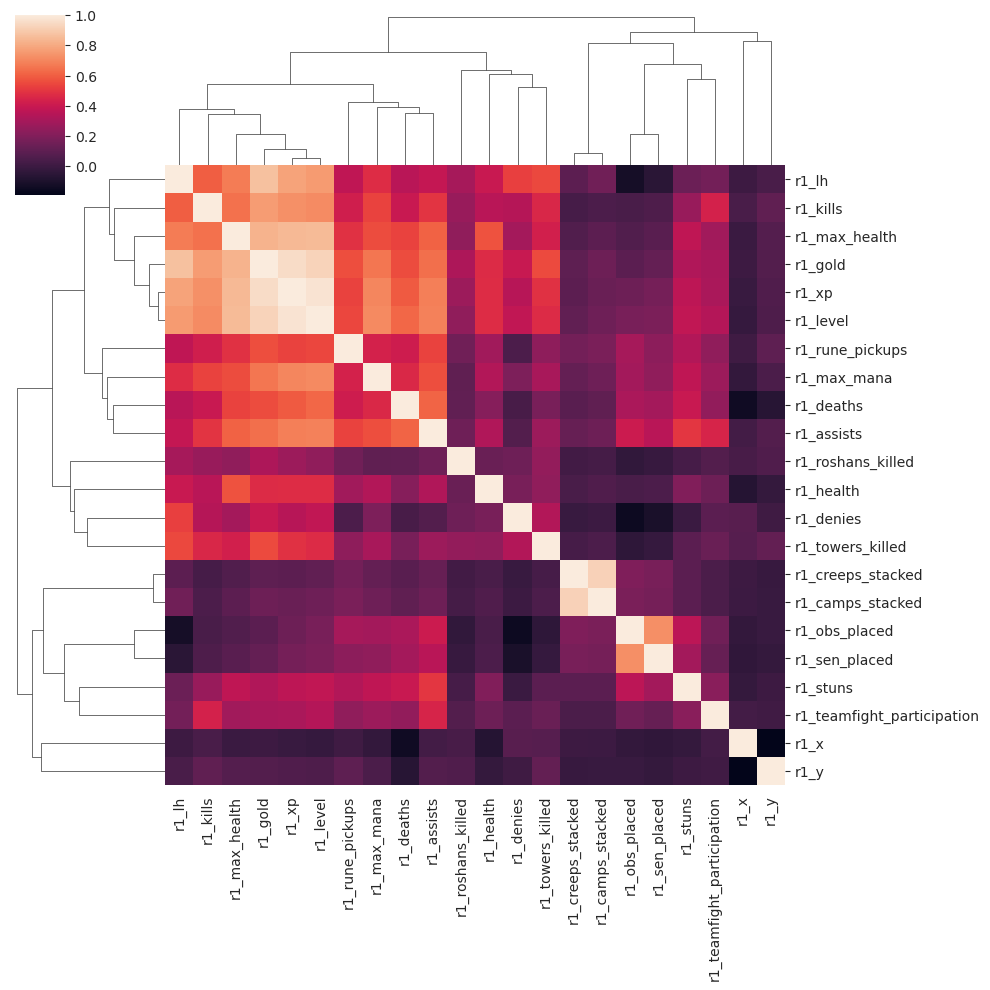

In [22]:
sns.clustermap(corr_hero);

Очень сильно коррелируют gold, hp, level, можно попробовать объединить в одну переменную experience просто суммой

In [23]:
df_train_features_new = df_train_features.copy()
for team in 'r', 'd':
    for i in range(1, 6):
        df_train_features_new[f'{team}{i}_experience'] = df_train_features_new[[f'{team}{i}_gold', f'{team}{i}_xp', f'{team}{i}_level']].sum(axis=1)
        df_train_features_new.drop([f'{team}{i}_gold', f'{team}{i}_xp', f'{team}{i}_level'], axis=1, inplace=True)

df_train_features_new

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r1_experience,r2_experience,r3_experience,r4_experience,r5_experience,d1_experience,d2_experience,d3_experience,d4_experience,d5_experience
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,9202,7299,4779,8674,5821,6111,4832,7049,5544,2563
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,177,177,177,177,177,97,97,97,97,97
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,764,1589,1537,1233,778,610,628,1391,1044,694
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,5919,6223,13197,12897,11578,11034,11722,7576,11476,6401
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,7488,4215,5446,5765,2787,2914,7088,8085,6494,2464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,45322,34523,24074,36748,45745,23269,35435,53165,52780,45611
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,33527,29754,48095,49302,29493,26568,40304,32339,41363,18637
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,9100,7051,8147,12912,7029,12078,7778,9912,9337,13946


In [24]:
numeric_features = ['kills', 'deaths', 'assists', 'denies', 'lh',
                    'health', 'max_health', 'max_mana', 'x', 'y',
                    'stuns', 'creeps_stacked', 'camps_stacked', 'experience',
                    'rune_pickups', 'teamfight_participation', 'towers_killed',
                    'roshans_killed', 'obs_placed', 'sen_placed']
numeric_cols = [f"{position}_{feature}" for position in hero_positions for feature in numeric_features]
numeric_cols.extend(['game_time', 'objectives_len', 'chat_len'])

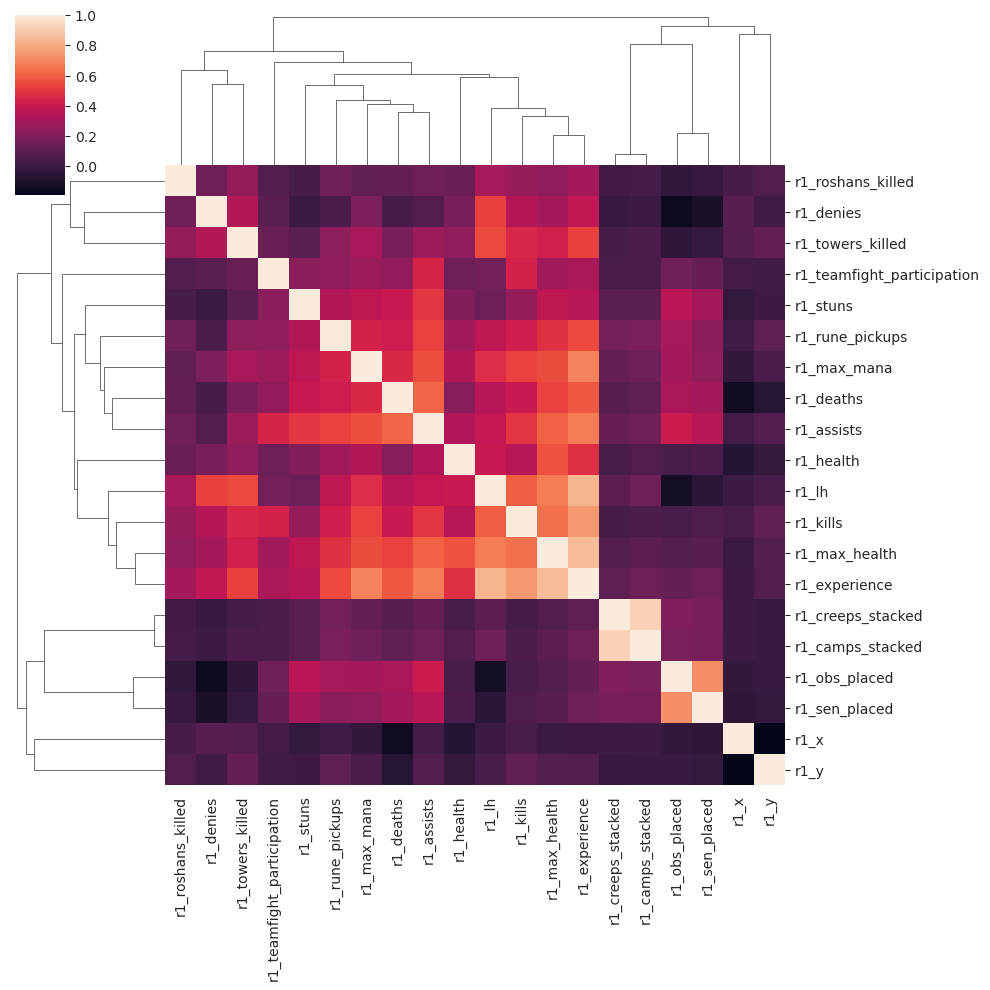

In [25]:
sns.clustermap(df_train_features_new[numeric_cols[:20]].corr());

Насколько я поняла Creeps_stack и camps_stack это одно и то же, поэтому можно оставить только первое. С obs и sen_placed уже не так очевидно, поэтому оставим. Еще можно доавить ранее предложенных признак KDA = K + A / D и заполнить наны нулями.

In [26]:
features_to_drop = ['camps_stacked']
columns_to_drop = [f"{position}_{feature}" for position in hero_positions for feature in features_to_drop]
df_train_features_new.drop(columns=columns_to_drop, axis=1, inplace=True)

In [27]:
for team in 'r', 'd':
    for i in range(1, 6):
        df_train_features_new[f'{team}{i}_kda'] = (df_train_features_new[f'{team}{i}_kills'] + 
                                      df_train_features_new[f'{team}{i}_assists']) / df_train_features_new[f'{team}{i}_deaths']
        df_train_features_new.drop([f'{team}{i}_kills', f'{team}{i}_assists', f'{team}{i}_deaths'], axis=1, inplace=True)                        
df_train_features_new

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_lh,r1_health,r1_max_health,...,r1_kda,r2_kda,r3_kda,r4_kda,r5_kda,d1_kda,d2_kda,d3_kda,d4_kda,d5_kda
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,52,1160,1160,...,3.500000,5.000000,5.000,inf,inf,0.500000,0.166667,0.666667,0.666667,0.000000
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,680,680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,1,0,740,740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,5,1,495,740,...,1.000000,1.600000,2.000,4.000000,2.000000,1.000000,inf,3.500000,2.000000,3.000000
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,9,40,495,960,...,5.000000,0.500000,4.000,1.000000,0.000000,6.000000,1.000000,inf,2.000000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,3,251,0,2805,...,1.636364,2.000000,1.875,3.333333,2.833333,1.437500,3.875000,26.000000,5.600000,4.000000
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,151,1478,2035,...,1.888889,1.833333,10.000,inf,3.333333,2.333333,1.333333,1.333333,0.333333,0.714286
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,0,59,880,880,...,1.000000,0.750000,0.500,1.333333,1.666667,inf,inf,5.000000,3.000000,10.000000


In [28]:
df_train_features_new.fillna(0, inplace=True)

Попробуем посмотреть на все корреляции вообще:

In [29]:
numeric_features = ['kda', 'denies', 'lh', 'health', 'max_health', 'max_mana', 'x', 'y',
                    'stuns', 'creeps_stacked', 'experience',
                    'rune_pickups', 'teamfight_participation', 'towers_killed',
                    'roshans_killed', 'obs_placed', 'sen_placed']
numeric_cols = [f"{position}_{feature}" for position in hero_positions for feature in numeric_features]
numeric_cols.extend(['game_time', 'objectives_len', 'chat_len'])

In [30]:
corr = df_train_features_new[numeric_cols].corr()

<Figure size 2000x2000 with 0 Axes>

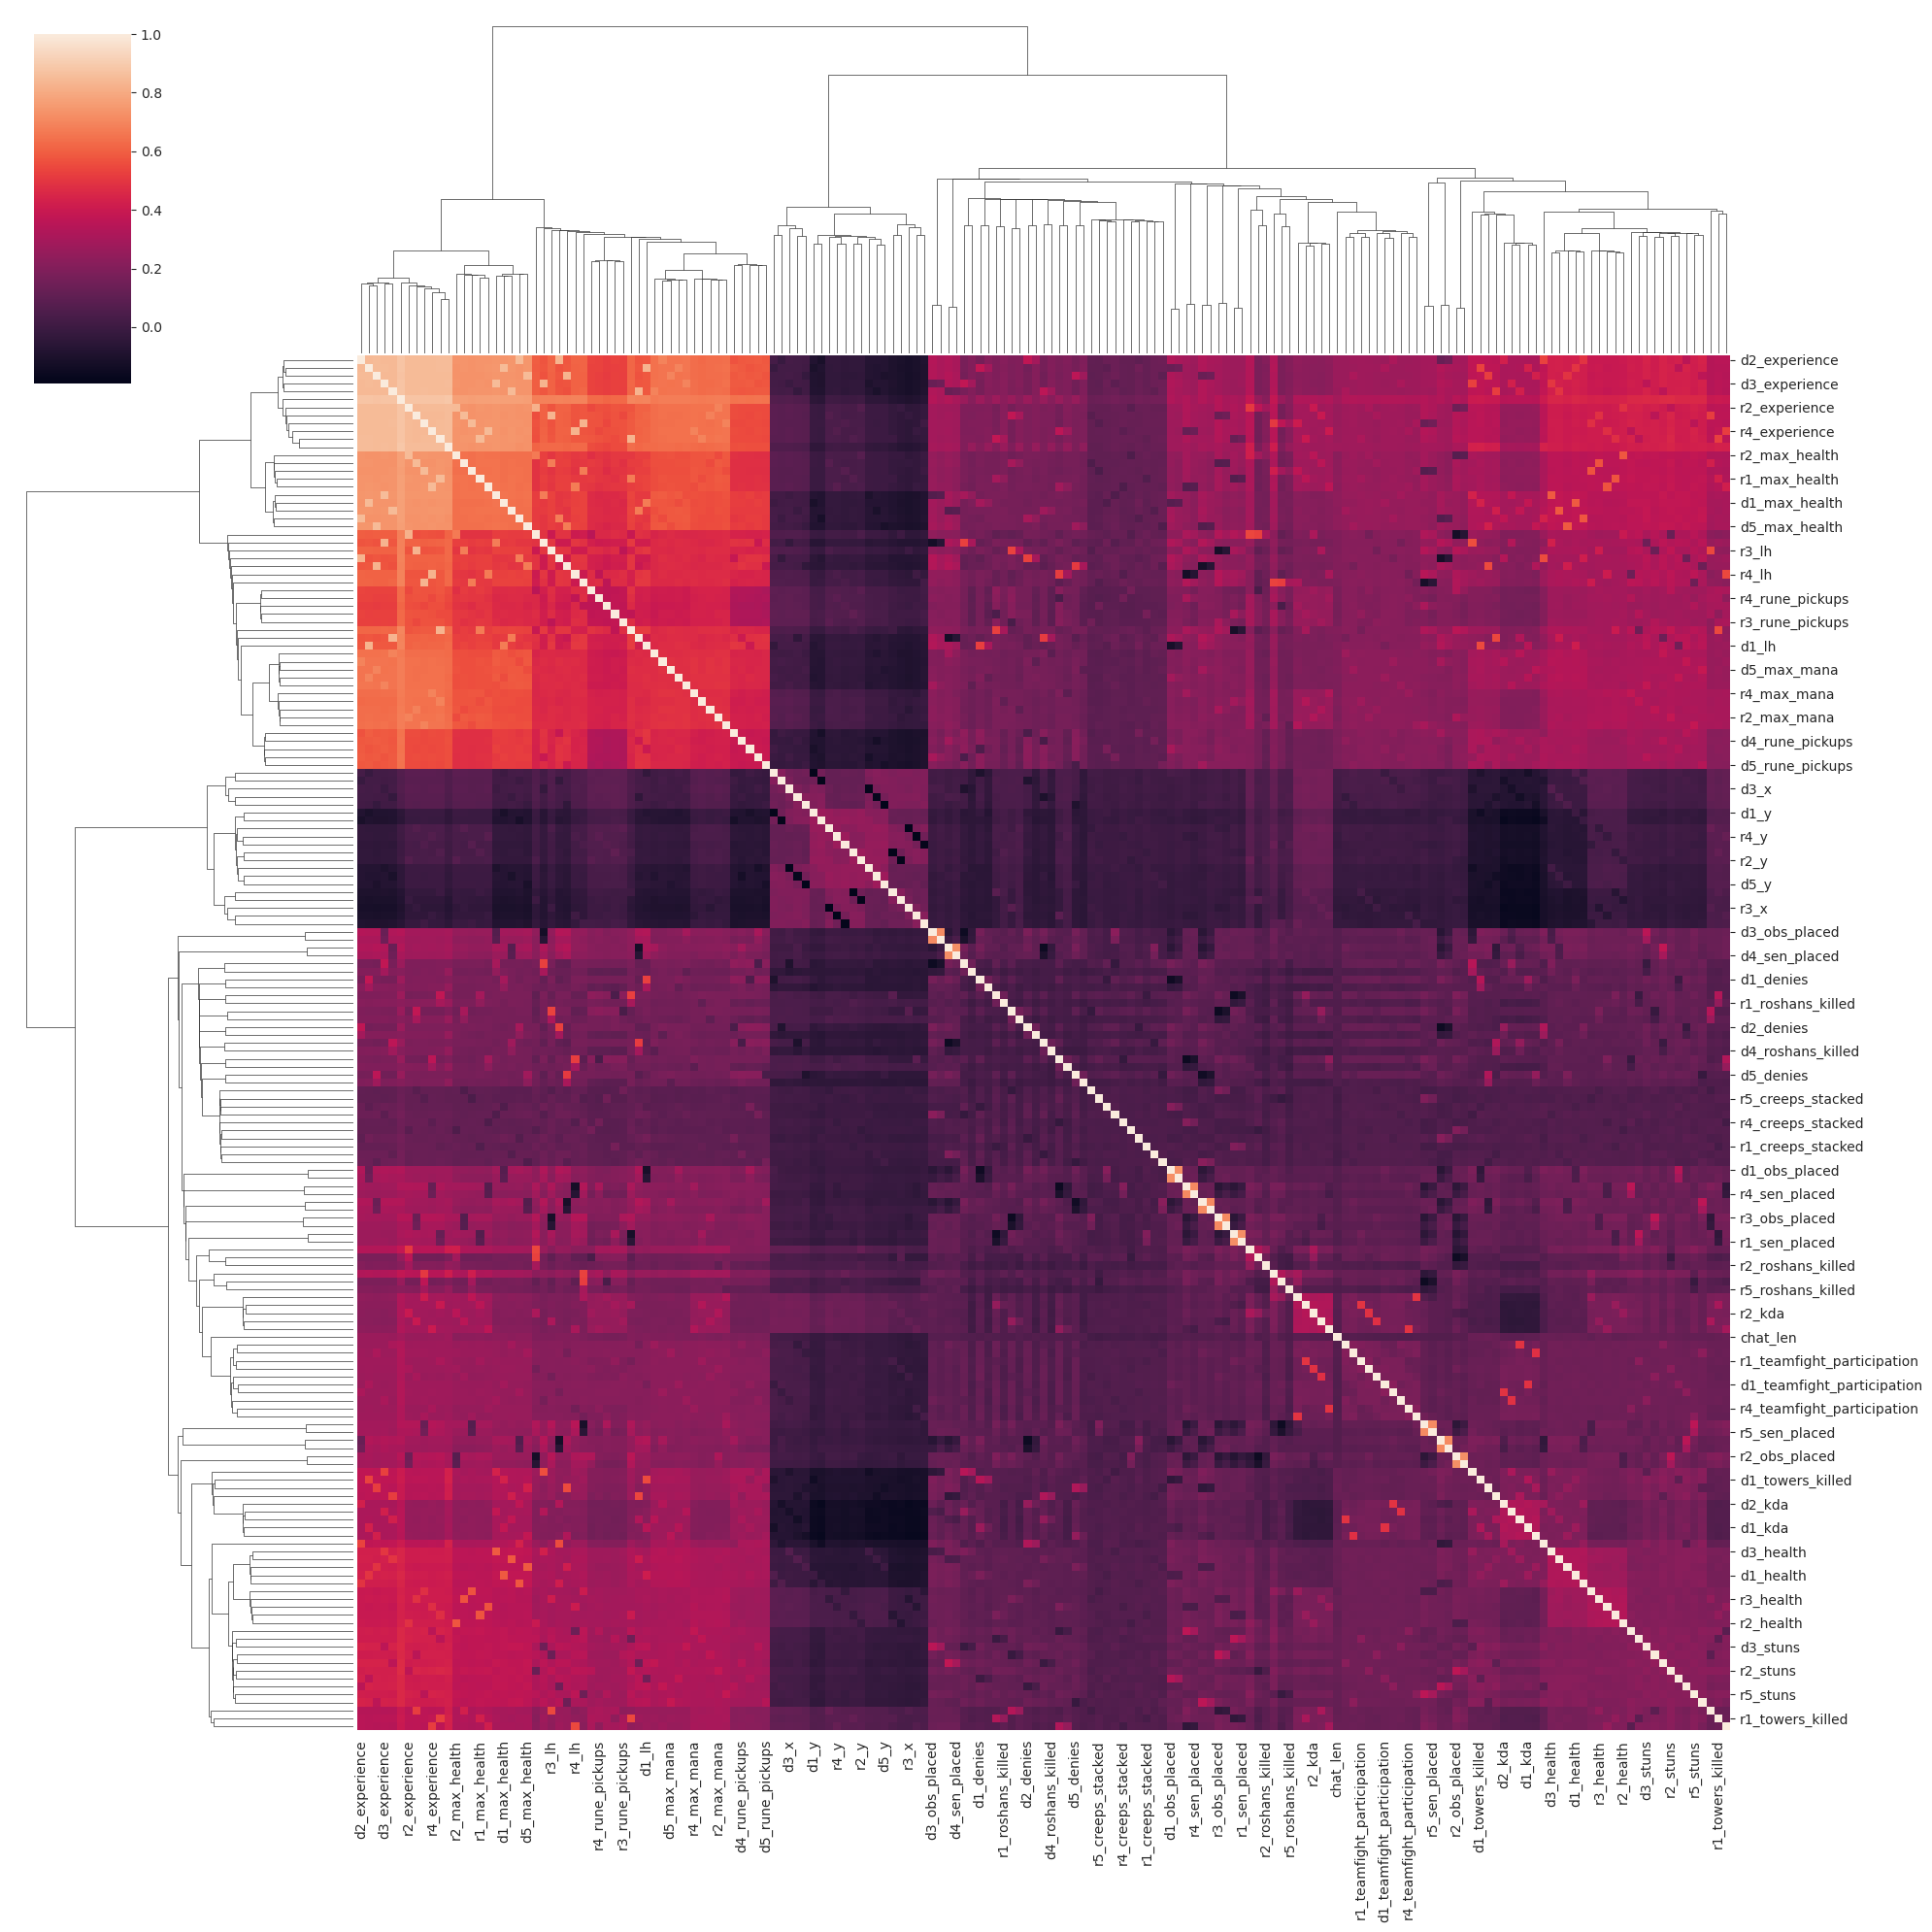

In [31]:
plt.figure(figsize=(20, 20)) 
sns.clustermap(df_train_features_new[numeric_cols].corr(), figsize=(20, 20));

Логичнее наверное сделать для одной команды, а не все сразу, а то кластеризуется по типу признака

In [32]:
corr = df_train_features_new[numeric_cols[85:]].corr()

<Figure size 4000x4000 with 0 Axes>

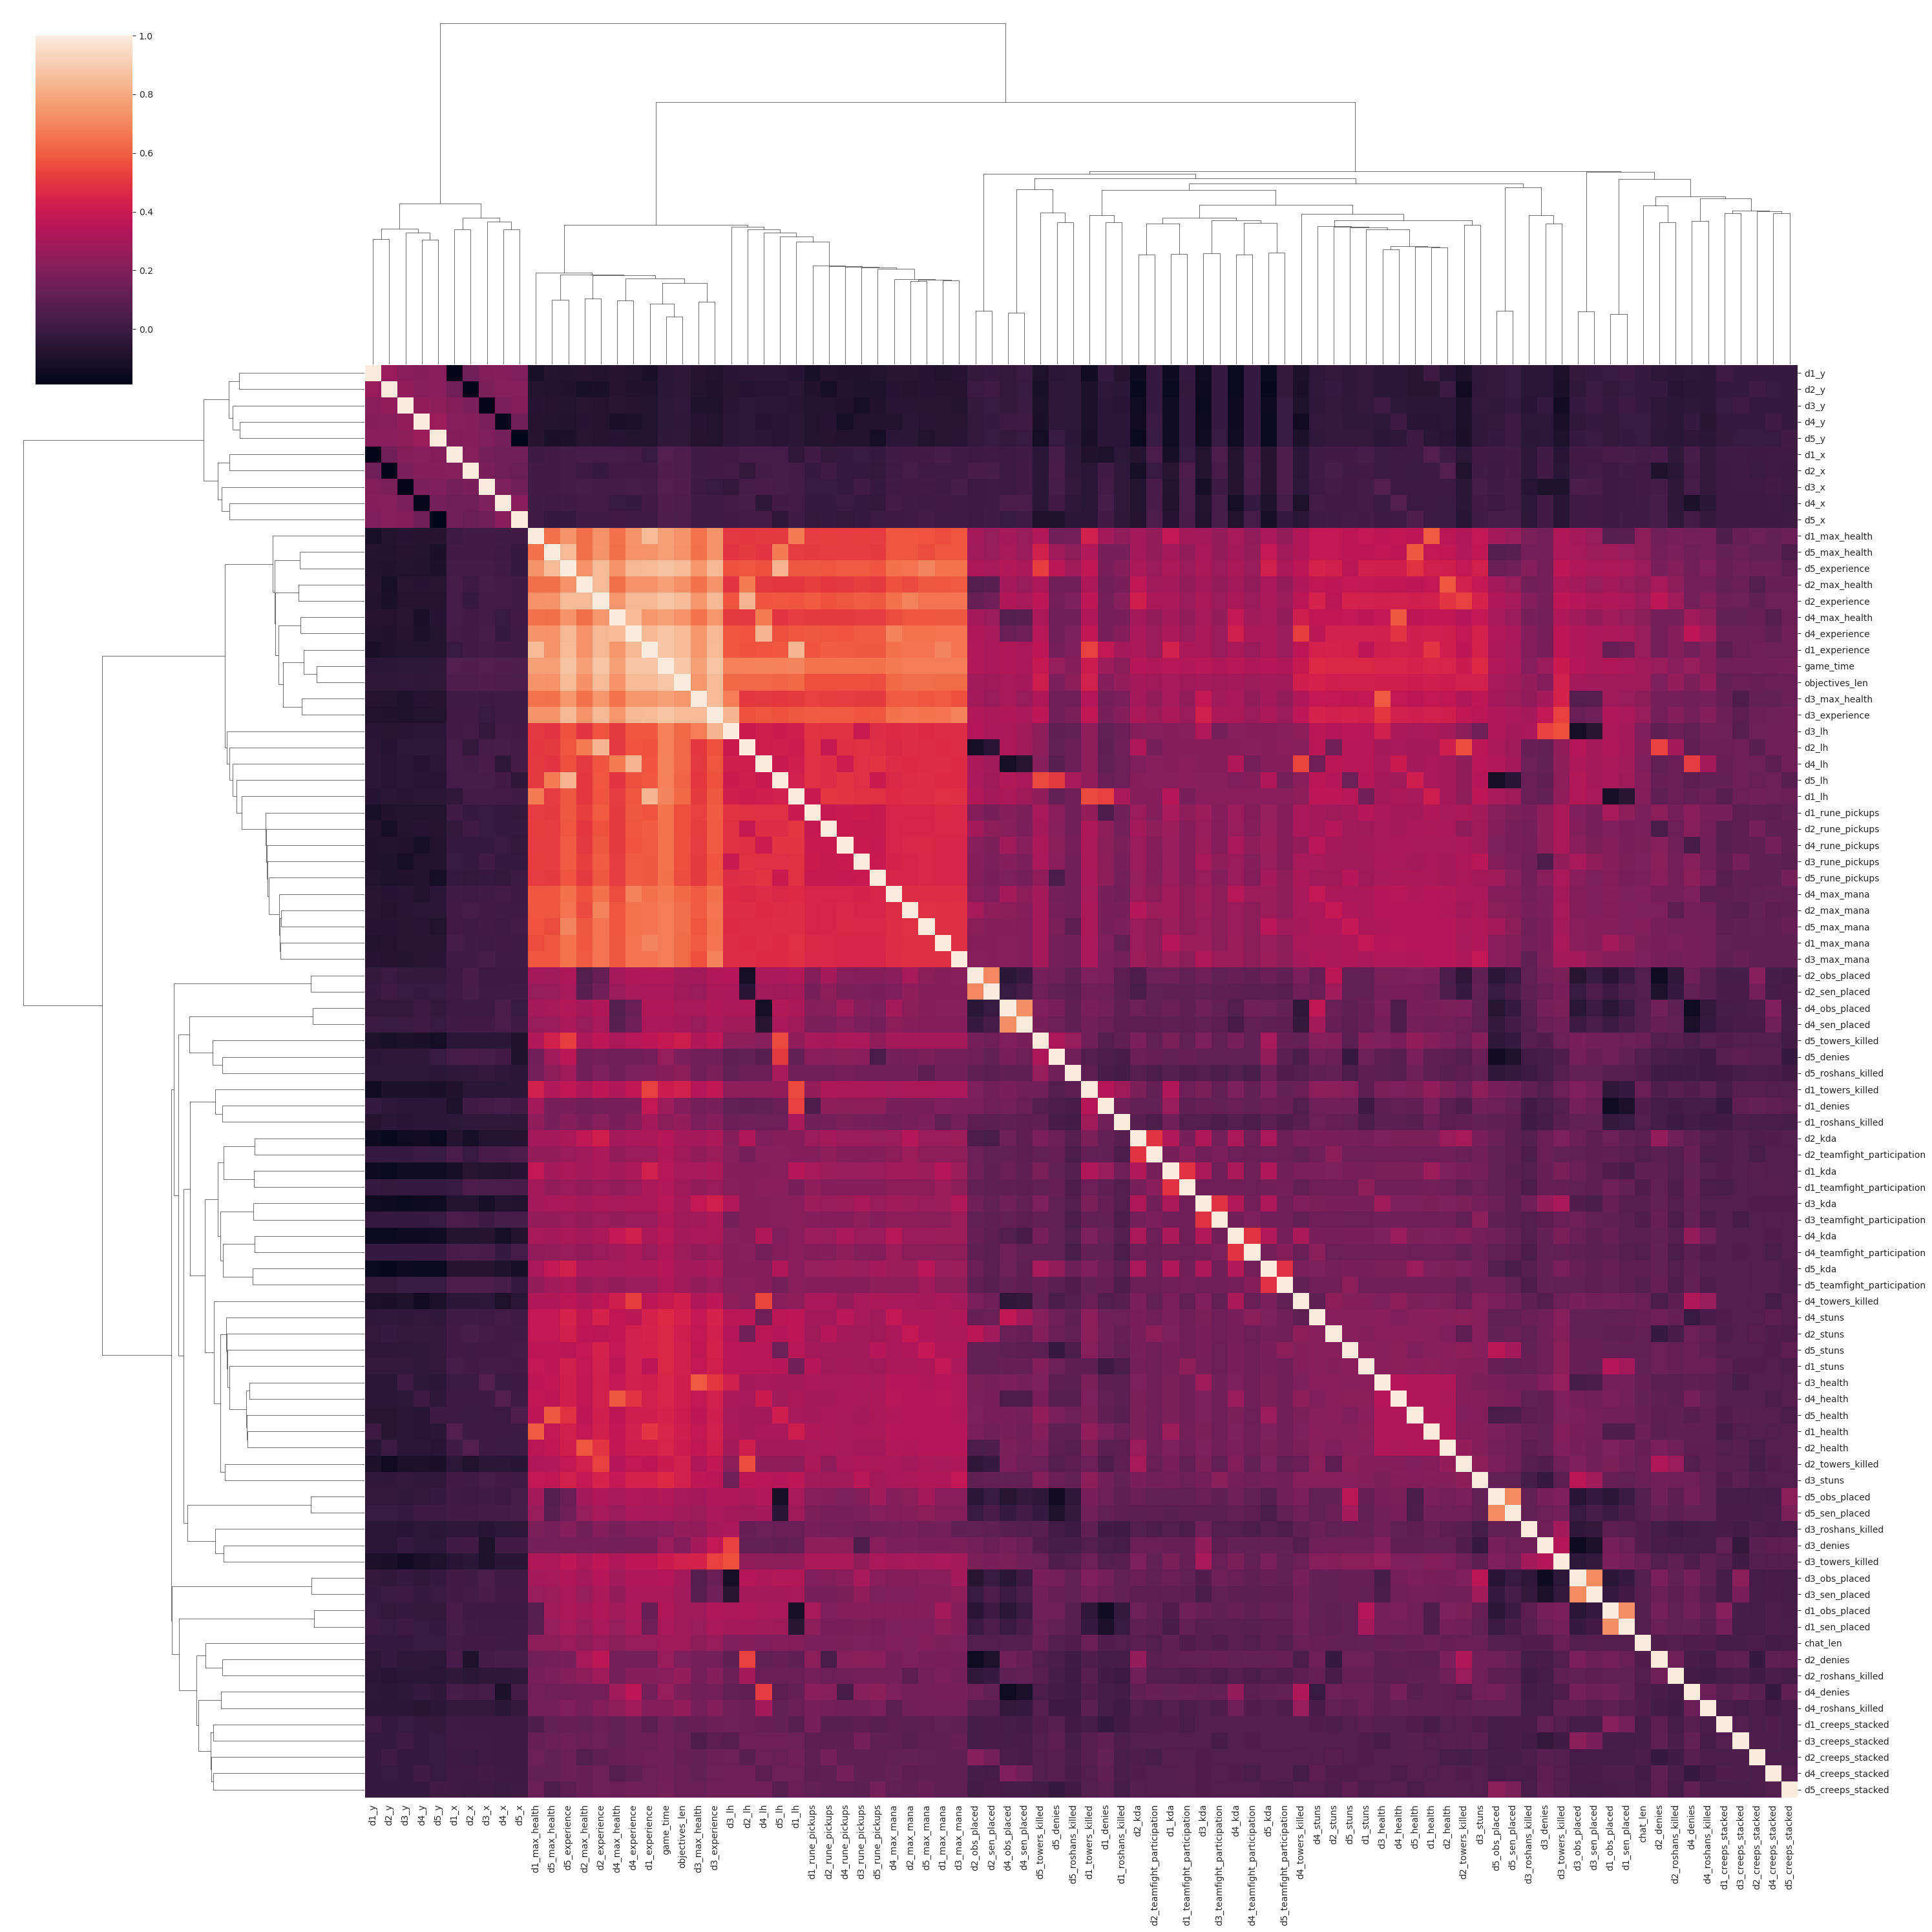

In [33]:
plt.figure(figsize=(40, 40)) 
sns.clustermap(corr, figsize=(30, 30));

В целом можно попробовать просуммировать max_health и max_experience, они дают самую сильную корреляцию. Или заменить их на min, mean, max признаки для команды в целом. Попробуем второй вариант.

In [34]:
features_to_alter = ['max_health', 'experience']
for feature in features_to_alter:
    for team in 'r', 'd':
        columns_of_interest = [f"{team}{i}_{feature}" for i in range(1, 6)]
        df_train_features_new[f'{team}_{feature}_min'] =  df_train_features_new[columns_of_interest].min(axis=1)
        df_train_features_new[f'{team}_{feature}_mean'] =  df_train_features_new[columns_of_interest].mean(axis=1)
        df_train_features_new[f'{team}_{feature}_max'] =  df_train_features_new[columns_of_interest].max(axis=1)
        df_train_features_new.drop(columns=columns_of_interest, axis=1, inplace=True)
        
df_train_features_new

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_lh,r1_health,r1_max_mana,...,r_max_health_max,d_max_health_min,d_max_health_mean,d_max_health_max,r_experience_min,r_experience_mean,r_experience_max,d_experience_min,d_experience_mean,d_experience_max
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,52,1160,566.93805,...,1380,700,900.0,1160,4779,7155.0,9202,2563,5219.8,7049
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,680,506.93800,...,720,600,636.0,660,177,177.0,177,97,97.0,97
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,1,0,740,290.93777,...,760,540,664.0,780,764,1180.2,1589,610,873.4,1391
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,5,1,495,816.93830,...,1360,800,1092.0,1340,5919,9962.8,13197,6401,9641.8,11722
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,9,40,495,530.93800,...,1100,620,836.0,1020,2787,5140.2,7488,2464,5409.0,8085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,3,251,0,2179.93970,...,2805,1640,2290.0,2635,24074,37282.4,45745,23269,42052.0,53165
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,151,1478,2197.93970,...,2515,1275,2253.0,3340,29493,38034.2,49302,18637,31842.2,41363
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,0,59,880,410.93790,...,1440,840,1282.0,1680,7029,8847.8,12912,7778,10610.2,13946


In [35]:
numeric_features = ['kda', 'denies', 'lh', 'health', 'max_mana', 'x', 'y',
                    'stuns', 'creeps_stacked', 
                    'rune_pickups', 'teamfight_participation', 'towers_killed',
                    'roshans_killed', 'obs_placed', 'sen_placed']
numeric_cols = [f"{position}_{feature}" for position in hero_positions for feature in numeric_features]
numeric_cols.extend(['game_time', 'objectives_len', 'chat_len',
                     'r_max_health_min', 'r_max_health_mean', 'r_max_health_max',
                     'd_max_health_min', 'd_max_health_mean', 'd_max_health_max'
                    ])

In [36]:
cols = numeric_cols[75:-6]
cols.extend(numeric_cols[-3:])
print(cols)

['d1_kda', 'd1_denies', 'd1_lh', 'd1_health', 'd1_max_mana', 'd1_x', 'd1_y', 'd1_stuns', 'd1_creeps_stacked', 'd1_rune_pickups', 'd1_teamfight_participation', 'd1_towers_killed', 'd1_roshans_killed', 'd1_obs_placed', 'd1_sen_placed', 'd2_kda', 'd2_denies', 'd2_lh', 'd2_health', 'd2_max_mana', 'd2_x', 'd2_y', 'd2_stuns', 'd2_creeps_stacked', 'd2_rune_pickups', 'd2_teamfight_participation', 'd2_towers_killed', 'd2_roshans_killed', 'd2_obs_placed', 'd2_sen_placed', 'd3_kda', 'd3_denies', 'd3_lh', 'd3_health', 'd3_max_mana', 'd3_x', 'd3_y', 'd3_stuns', 'd3_creeps_stacked', 'd3_rune_pickups', 'd3_teamfight_participation', 'd3_towers_killed', 'd3_roshans_killed', 'd3_obs_placed', 'd3_sen_placed', 'd4_kda', 'd4_denies', 'd4_lh', 'd4_health', 'd4_max_mana', 'd4_x', 'd4_y', 'd4_stuns', 'd4_creeps_stacked', 'd4_rune_pickups', 'd4_teamfight_participation', 'd4_towers_killed', 'd4_roshans_killed', 'd4_obs_placed', 'd4_sen_placed', 'd5_kda', 'd5_denies', 'd5_lh', 'd5_health', 'd5_max_mana', 'd5_x',

In [37]:
numeric_cols[-3:]

['d_max_health_min', 'd_max_health_mean', 'd_max_health_max']

In [38]:
cols = numeric_cols[75:-6]
cols.extend(numeric_cols[-3:])
corr = df_train_features_new[cols].corr()

<Figure size 4000x4000 with 0 Axes>

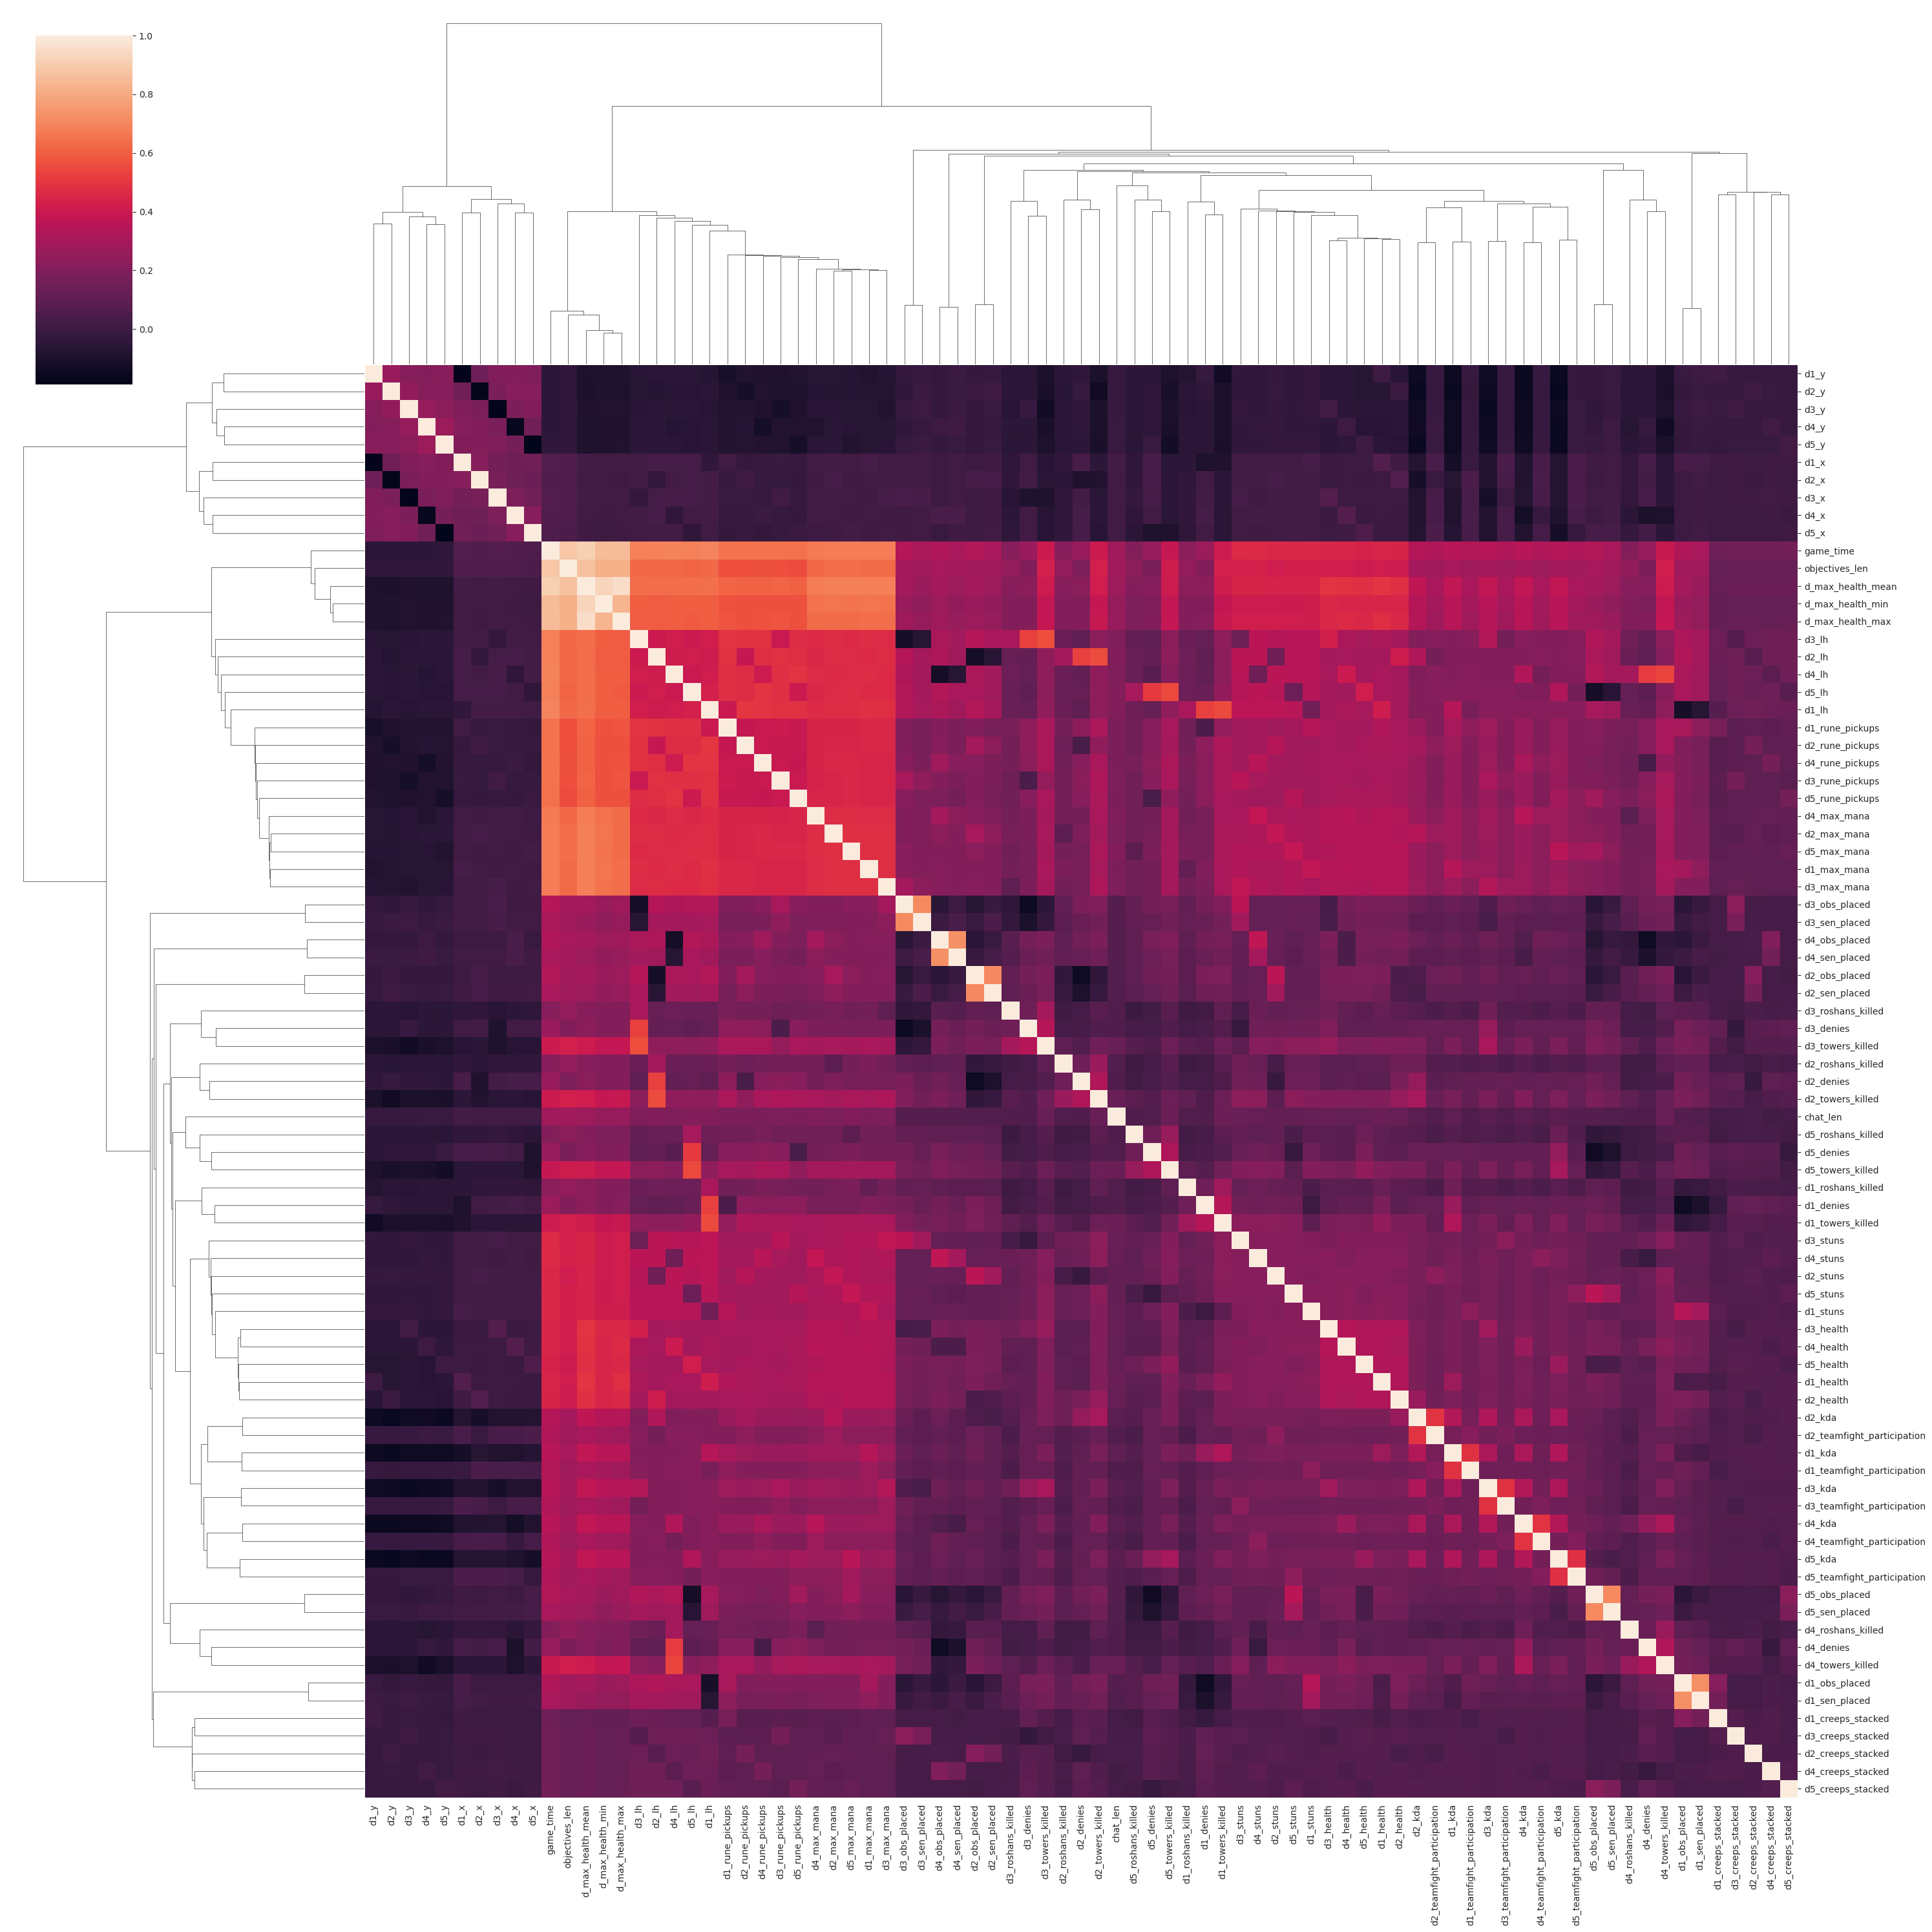

In [39]:
plt.figure(figsize=(40, 40)) 
sns.clustermap(corr, figsize=(30, 30));

In [40]:
cols_of_interest = ['d_max_health_min', 'd_max_health_mean', 'd_max_health_max',
                    'game_time', 'objectives_len']

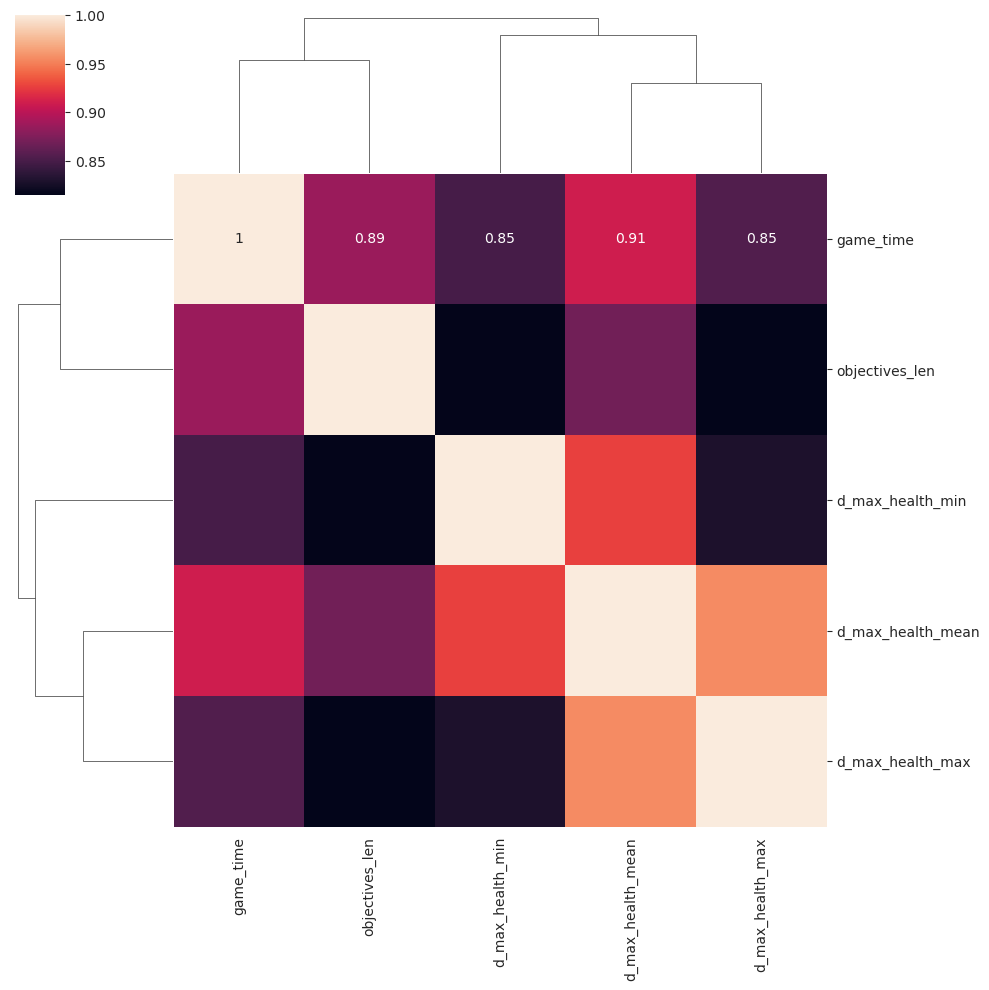

In [41]:
sns.clustermap(df_train_features_new[cols_of_interest].corr(), annot=True);

Предлагаю выкинуть min и max и оставить среднее, а еще выкинуть game_time и objective_len, они оч сильно коррелируют

In [42]:
df_train_features_new.drop(['game_time', 'objectives_len',
                            'r_max_health_min', 'r_max_health_max',
                            'd_max_health_min', 'd_max_health_min'], axis=1, inplace=True)
df_train_features_new

,game_mode,lobby_type,chat_len,r1_hero_id,r1_denies,r1_lh,r1_health,r1_max_mana,r1_x,r1_y,...,d5_kda,r_max_health_mean,d_max_health_mean,d_max_health_max,r_experience_min,r_experience_mean,r_experience_max,d_experience_min,d_experience_mean,d_experience_max
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,4,0,10,15,7,52,1160,566.93805,76,78,...,0.000000,1036.0,900.0,1160,4779,7155.0,9202,2563,5219.8,7049
6db558535151ea18ca70a6892197db41,23,0,0,101,0,0,680,506.93800,118,118,...,0.000000,632.0,636.0,660,177,177.0,177,97,97.0,97
19c39fe2af2b547e48708ca005c6ae74,22,7,0,57,1,0,740,290.93777,92,148,...,0.000000,708.0,664.0,780,764,1180.2,1589,610,873.4,1391
c96d629dc0c39f0c616d1949938a6ba6,22,0,0,119,5,1,495,816.93830,112,112,...,3.000000,1098.0,1092.0,1340,5919,9962.8,13197,6401,9641.8,11722
156c88bff4e9c4668b0f53df3d870f1b,22,7,2,12,9,40,495,530.93800,120,118,...,2.500000,912.0,836.0,1020,2787,5140.2,7488,2464,5409.0,8085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,22,0,8,99,3,251,0,2179.93970,152,148,...,4.000000,1998.0,2290.0,2635,24074,37282.4,45745,23269,42052.0,53165
308faee28efee2e66b39f9f2ba6ea9cf,22,0,5,22,3,151,1478,2197.93970,132,136,...,0.714286,1970.0,2253.0,3340,29493,38034.2,49302,18637,31842.2,41363
6066cc7417b43c749d551e123d00f0c8,4,0,0,1,0,59,880,410.93790,152,92,...,10.000000,1095.0,1282.0,1680,7029,8847.8,12912,7778,10610.2,13946


In [43]:
col_to_remove = ['game_time', 'objectives_len',
                'r_max_health_min', 'r_max_health_max',
                'd_max_health_min', 'd_max_health_max']
numeric_cols = [col for col in numeric_cols if col not in col_to_remove]

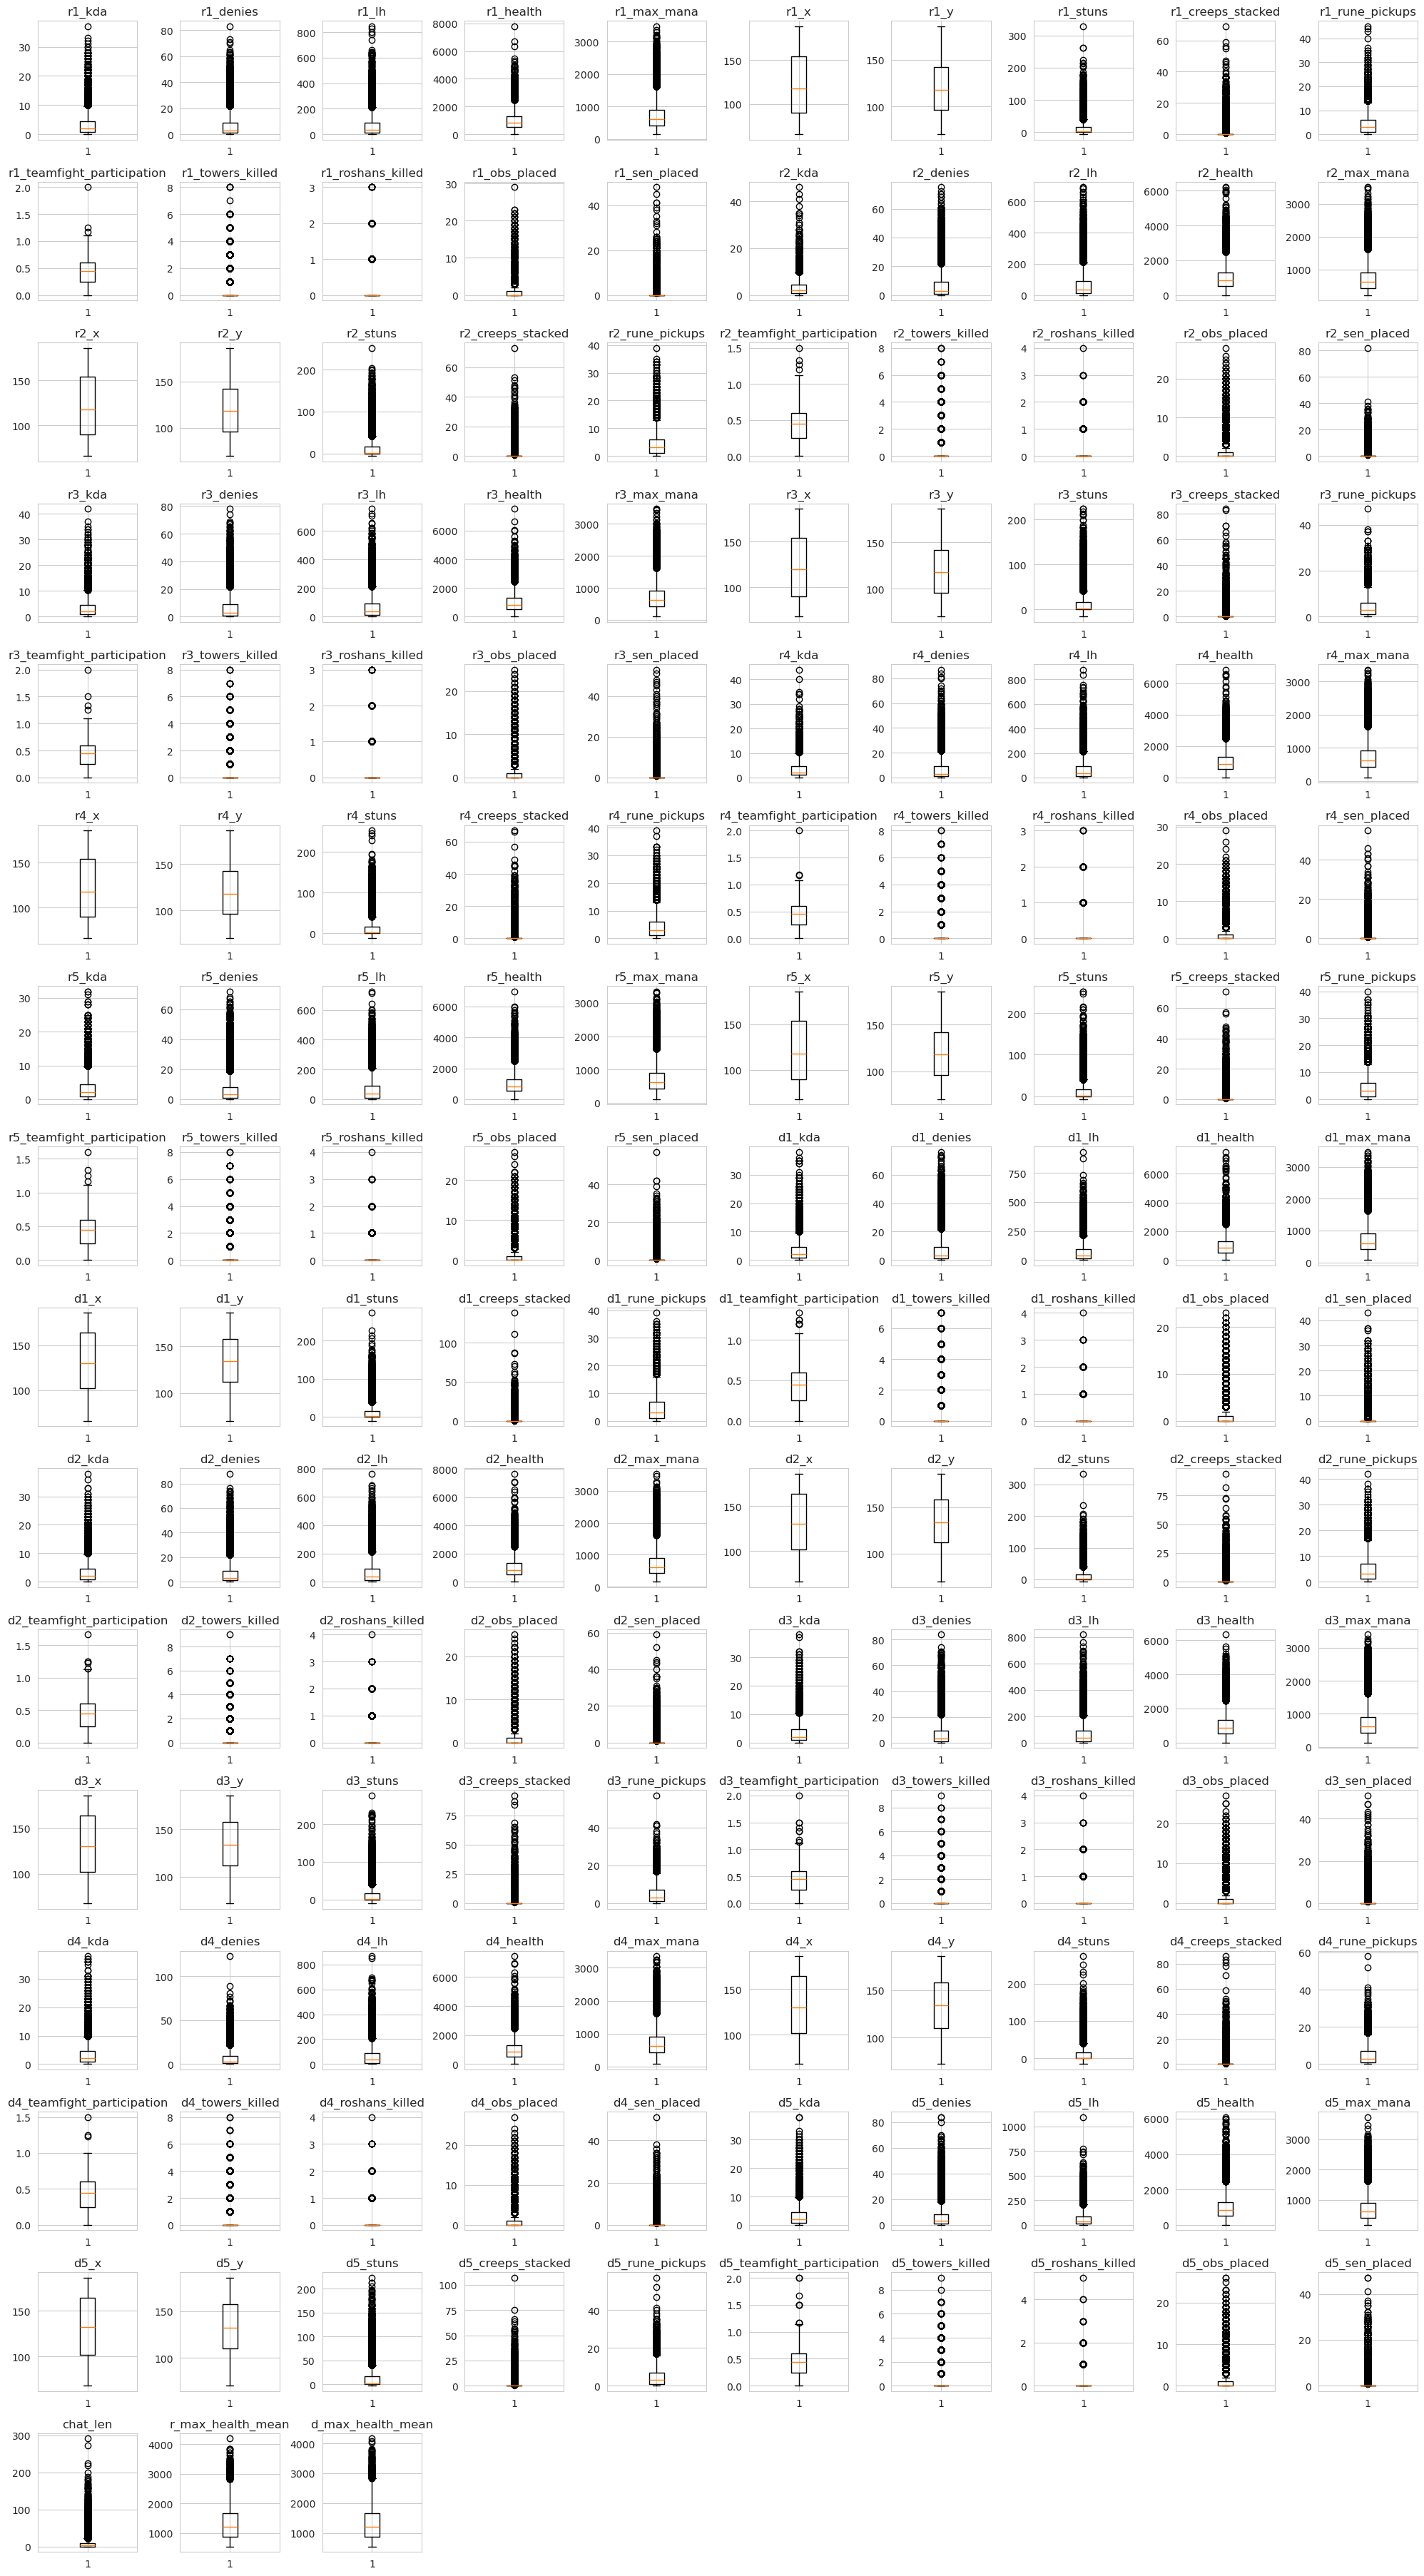

In [44]:
plt.figure(figsize=(20, 45))
for i, col in enumerate(numeric_cols):
    plt.subplot(20, 10, i+1)
    plt.boxplot(df_train_features_new[col].to_numpy())
    plt.title(col)
    
plt.tight_layout()
plt.show()

Здесь меня все устраивает, не смотря даже на как будто выбросы и какие-то более категориальные как будто величины. По смуслу мне кажется их можно все еще считать численными приззнаками + я буду использовать лес и мне это не так важно.

Я буду использовать xgboost и последоватлеьно подбирать параметры.

In [45]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [46]:
X.shape, y.shape

((31698, 245), (31698,))

Сначaла подбираем основные параметры, которые сильнее всего влияют на качество модели: max_depth, learning_rate, subsample, n_estimators.

In [59]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1), 
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1), 
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1) 
}


def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    xgb_model = xgb.XGBClassifier(**params)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    
    score = cross_val_score(xgb_model, X, y, cv=cv, scoring='roc_auc').mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

In [60]:
trials = Trials()

best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

best_score = 1 - min([trial['result']['loss'] for trial in trials.trials])

100%|██████████| 100/100 [22:24<00:00, 13.44s/trial, best loss: 0.20604306895899316]
Best set of hyperparameters:  {'learning_rate': 0.08095795920720701, 'max_depth': 5.0, 'n_estimators': 196.0, 'subsample': 0.7966324574015148}
Best score (accuracy):  0.7939569310410068


In [61]:
print("Best set of hyperparameters: ", best)
print("Best score (roc_auc): ", best_score)

Best set of hyperparameters:  {'learning_rate': 0.08095795920720701, 'max_depth': 5.0, 'n_estimators': 196.0, 'subsample': 0.7966324574015148}
Best score (roc_auc):  0.7939569310410068


Далее для этих параметров подберем gamma, min_child_weight

In [67]:
space = {
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
}

def objective(params):
    params['min_child_weight'] = int(params['min_child_weight'])
    xgb_model = xgb.XGBClassifier(learning_rate=0.08095795920720701,
        max_depth=5,
        n_estimators=196,
        subsample=0.7966324574015148,
        **params)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    
    score = cross_val_score(xgb_model, X, y, cv=cv, scoring='roc_auc').mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

In [68]:
trials = Trials()

best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

best_score = 1 - min([trial['result']['loss'] for trial in trials.trials])

100%|██████████| 100/100 [26:57<00:00, 16.17s/trial, best loss: 0.20465017606511693]


In [69]:
print("Best set of hyperparameters: ", best)
print("Best score (roc_auc): ", best_score)

Best set of hyperparameters:  {'gamma': 2.3074644348979114, 'min_child_weight': 10.0}
Best score (roc_auc):  0.7953498239348831


Теперь выберем colsample_bytree

In [75]:
space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

def objective(params):
    xgb_model = xgb.XGBClassifier(learning_rate=0.08095795920720701,
        max_depth=5,
        n_estimators=196,
        subsample=0.7966324574015148,
        gamma=2.3074644348979114,
        min_child_weight=10,
        **params)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    
    score = cross_val_score(xgb_model, X, y, cv=cv, scoring='roc_auc').mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

In [76]:
trials = Trials()

best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

best_score = 1 - min([trial['result']['loss'] for trial in trials.trials])

100%|██████████| 100/100 [22:23<00:00, 13.44s/trial, best loss: 0.2044770941403502]


In [77]:
print("Best set of hyperparameters: ", best)
print("Best score (roc_auc): ", best_score)

Best set of hyperparameters:  {'colsample_bytree': 0.5460755055592035}
Best score (roc_auc):  0.7955229058596498


И reg_alpha

In [80]:
space = {
    'reg_alpha': hp.uniform('reg_alpha', 1e-5, 100)
}

def objective(params):
    xgb_model = xgb.XGBClassifier(learning_rate=0.08095795920720701,
        max_depth=5,
        n_estimators=196,
        subsample=0.7966324574015148,
        gamma=2.3074644348979114,
        min_child_weight=10,
        colsample_bytree=0.5460755055592035,
        **params)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    
    score = cross_val_score(xgb_model, X, y, cv=cv, scoring='roc_auc').mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

In [81]:
trials = Trials()

best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

best_score = 1 - min([trial['result']['loss'] for trial in trials.trials])

100%|██████████| 100/100 [18:42<00:00, 11.23s/trial, best loss: 0.20335933441472043]


In [82]:
print("Best set of hyperparameters: ", best)
print("Best score (roc_auc): ", best_score)

Best set of hyperparameters:  {'reg_alpha': 7.778058059328409}
Best score (roc_auc):  0.7966406655852796


И самое интересное - теперь уменьшим learning rate и увеличим n_estimators. Качество сильно улучшится!

In [88]:
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)), 
    'n_estimators': hp.quniform('n_estimators', 200, 1000, 10) 
}

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    
    xgb_model = xgb.XGBClassifier(
        max_depth=5,
        subsample=0.7966324574015148,
        gamma=2.3074644348979114,
        min_child_weight=10,
        colsample_bytree=0.5460755055592035,
        reg_alpha = 7.778058059328409,
        **params)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    
    score = cross_val_score(xgb_model, X, y, cv=cv, scoring='roc_auc').mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

In [89]:
trials = Trials()

best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

best_score = 1 - min([trial['result']['loss'] for trial in trials.trials])

100%|██████████| 100/100 [1:08:39<00:00, 41.19s/trial, best loss: 0.19531458189621698]


In [90]:
print("Best set of hyperparameters: ", best)
print("Best score (roc_auc): ", best_score)

Best set of hyperparameters:  {'learning_rate': 0.052477299552573915, 'n_estimators': 960.0}
Best score (roc_auc):  0.804685418103783


Теперь сделаем посылку. Для этого нужно пердобработать тестовые данные, чтобы добавить туда нужные признаки

In [48]:
df_test_features = pd.read_csv( "test_data.csv",
                                    index_col="match_id_hash")

In [49]:
df_test_features_new = df_test_features.copy()
for team in 'r', 'd':
    for i in range(1, 6):
        df_test_features_new[f'{team}{i}_experience'] = df_test_features_new[[f'{team}{i}_gold', f'{team}{i}_xp', f'{team}{i}_level']].sum(axis=1)
        df_test_features_new.drop([f'{team}{i}_gold', f'{team}{i}_xp', f'{team}{i}_level'], axis=1, inplace=True)
        
hero_positions = ['r1', 'r2', 'r3', 'r4', 'r5', 'd1', 'd2', 'd3', 'd4', 'd5']
features_to_drop = ['camps_stacked']
columns_to_drop = [f"{position}_{feature}" for position in hero_positions for feature in features_to_drop]
df_test_features_new.drop(columns=columns_to_drop, axis=1, inplace=True)

for team in 'r', 'd':
    for i in range(1, 6):
        df_test_features_new[f'{team}{i}_kda'] = (df_test_features_new[f'{team}{i}_kills'] + 
                                      df_test_features_new[f'{team}{i}_assists']) / df_test_features_new[f'{team}{i}_deaths']
        df_test_features_new.drop([f'{team}{i}_kills', f'{team}{i}_assists', f'{team}{i}_deaths'], axis=1, inplace=True)     
        
df_test_features_new.fillna(0, inplace=True)

features_to_alter = ['max_health', 'experience']
for feature in features_to_alter:
    for team in 'r', 'd':
        columns_of_interest = [f"{team}{i}_{feature}" for i in range(1, 6)]
        df_test_features_new[f'{team}_{feature}_min'] =  df_test_features_new[columns_of_interest].min(axis=1)
        df_test_features_new[f'{team}_{feature}_mean'] =  df_test_features_new[columns_of_interest].mean(axis=1)
        df_test_features_new[f'{team}_{feature}_max'] =  df_test_features_new[columns_of_interest].max(axis=1)
        df_test_features_new.drop(columns=columns_of_interest, axis=1, inplace=True)
        
df_test_features_new.drop(['game_time', 'objectives_len',
                            'r_max_health_min', 'r_max_health_max',
                            'd_max_health_min', 'd_max_health_min'], axis=1, inplace=True)

In [64]:
df_train_features_new

,game_mode,lobby_type,chat_len,r1_hero_id,r1_denies,r1_lh,r1_health,r1_max_mana,r1_x,r1_y,...,d5_kda,r_max_health_mean,d_max_health_mean,d_max_health_max,r_experience_min,r_experience_mean,r_experience_max,d_experience_min,d_experience_mean,d_experience_max
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,4,0,10,15,7,52,1160,566.93805,76,78,...,0.000000,1036.0,900.0,1160,4779,7155.0,9202,2563,5219.8,7049
6db558535151ea18ca70a6892197db41,23,0,0,101,0,0,680,506.93800,118,118,...,0.000000,632.0,636.0,660,177,177.0,177,97,97.0,97
19c39fe2af2b547e48708ca005c6ae74,22,7,0,57,1,0,740,290.93777,92,148,...,0.000000,708.0,664.0,780,764,1180.2,1589,610,873.4,1391
c96d629dc0c39f0c616d1949938a6ba6,22,0,0,119,5,1,495,816.93830,112,112,...,3.000000,1098.0,1092.0,1340,5919,9962.8,13197,6401,9641.8,11722
156c88bff4e9c4668b0f53df3d870f1b,22,7,2,12,9,40,495,530.93800,120,118,...,2.500000,912.0,836.0,1020,2787,5140.2,7488,2464,5409.0,8085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,22,0,8,99,3,251,0,2179.93970,152,148,...,4.000000,1998.0,2290.0,2635,24074,37282.4,45745,23269,42052.0,53165
308faee28efee2e66b39f9f2ba6ea9cf,22,0,5,22,3,151,1478,2197.93970,132,136,...,0.714286,1970.0,2253.0,3340,29493,38034.2,49302,18637,31842.2,41363
6066cc7417b43c749d551e123d00f0c8,4,0,0,1,0,59,880,410.93790,152,92,...,10.000000,1095.0,1282.0,1680,7029,8847.8,12912,7778,10610.2,13946


In [70]:
df_train_features_new.replace([np.inf, -np.inf], 1e10, inplace=True)

In [71]:
X = df_train_features_new.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [73]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [74]:
%%time
xgb_model = xgb.XGBClassifier(
        learning_rate=0.02477299552573915, 
        n_estimators=960,
        max_depth=5,
        subsample=0.7966324574015148,
        gamma=2.3074644348979114,
        min_child_weight=10,
        colsample_bytree=0.5460755055592035,
        reg_alpha = 7.778058059328409)

cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 31min 8s, sys: 59.9 s, total: 32min 8s
Wall time: 1min 8s


In [75]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_xgb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8022831528362652


In [77]:
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5460755055592035, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.3074644348979114, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02477299552573915, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=960, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [78]:
X_test = df_test_features_new.values
y_test_pred = xgb_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features_new.index)

In [79]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-04-08_16-36-37.csv


Там было 0.81705:)